In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import numpy as np
import time
import os
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
import time 
import json

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchviz import make_dot
from utils import one_hot_encode, one_hot_decode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from utils import load_gfp_data, count_substring_mismatch, get_mutation, to_tensor
from pomegranate import State, DiscreteDistribution, HiddenMarkovModel
from sklearn.model_selection import train_test_split
from Bio.Alphabet import IUPAC

In [2]:
class Model():
    
    def __init__(self, args):
        self.args = args 
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True, weights=None): 
        pass 
    
    def predict(self, dataloader, verbose=False, logger=None, save_model=True, weights=None): 
        pass
        
    def evaluate(self, dataloader, verbose=False, logger=None, save_model=True, weights=None): 
        pass 
        
    def sample(self, num_samples=1, length=10):
        pass 
    
    def show_model(self): 
        pass
        
    def save_model(self, path): 
        pass 
    
    def load_model(self, path): 
        pass 
    
    def plot_model(self, save_fig_dir): 
        pass

    def plot_history(self, save_fig_dir): 
        pass

In [56]:
class VAE(nn.Module):
    
    # change architecture later to make it deeper if it's not good enough to capture all data
    def __init__(self, input_size, hidden_size, latent_dim, num_characters, seq_length):
        super(VAE, self).__init__() 
        self.num_characters = num_characters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.fc5 = nn.Linear(num_characters, num_characters)
        assert(seq_length * num_characters == input_size)
        
    def encode(self, x):
        # input should be one hot encoded. shape - (batch_size, alphabet x sequence_length)
        h1 = F.elu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, softmax=False):
        batch_size = z.shape[0]
        h3 = F.elu(self.fc3(z))
        h4 = self.fc4(h3).view(batch_size, self.seq_length, self.num_characters)
        if softmax:
            return F.softmax(self.fc5(h4), dim=2)
        else:
            return self.fc5(h4)
        
    def forward(self, x):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters)
        Output: recon_x: is the one hot encoded batch_size x seq_length x num_characters vector
                mu: is the hidden state mean with dimension batch_size x hidden_size
                logvar: is the hidden state log variance with dimension batch_size x hidden_size
        """
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z, softmax=False), mu, logvar

In [57]:
class GenerativeVAE(Model): 
    
    def __init__(self, args):     
        """
        Initializes the VAE to be a generative VAE
        
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.model : string 
            type of model
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int
            the size of the input
        args.hidden_size : int
            the size of the hidden layer
        args.latent_dim: int 
            the size of the latent dimension
        args.device : device
            the device used: cpu or gpu
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.beta : float
            sets the beta parameter for the KL divergence loss
        args.vocabulary : string
            all the characters in the context of the problem
        args.seq_length : int 
            maximum seq length of the DNA sequence
        args.batch_size : int
            batch size of the model
        """
        Model.__init__(self, args)        
        self.name = args["name"]
        self.model = args["model"]
        self.description = args["description"]
        self.input = args["input"]
        self.hidden_size = args["hidden_size"]
        self.latent_dim = args["latent_dim"]
        self.device = args["device"]
        self.epochs = args["epochs"]
        self.beta = args["beta"]
        self.all_characters = args["vocabulary"]
        self.seq_length = args["seq_length"]
        self.batch_size = args["batch_size"]
        self.learning_rate = args["learning_rate"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = VAE(self.input, self.hidden_size, self.latent_dim, self.num_characters, self.seq_length)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loss_history = []
        self.test_loss_history = []
        assert(self.model == "VAE")
        assert(self.seq_length * self.num_characters == self.input)
        
    def loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of shape batch_size x self.hidden_size
        Output: elbo loss
        """
        outputs = F.log_softmax(recon_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, self.num_characters)).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return CE + KLD
    
    def cross_entropy_loss(self, recon_x, x):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
        Output: traditional cross entropy loss
        """
        loss = nn.CrossEntropyLoss(reduction='sum')
        input = recon_x.permute(0, 2, 1)
        _, target = x.view(x.shape[0], -1, self.num_characters).max(dim=2)
        target = target.long()
        return loss(input, target)
    
    def kld_loss(self, mu, logvar): 
        """
        Input:  mu and logvar are the hidden states of shape batch_size x self.hidden_size
        Output: the kl divergence between the mu and logvar and a standard unit gaussian. 
        """
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True):
        start_time = time.time()
        self.train_loss_history, self.train_recon_loss_history, self.train_kld_loss_history = [], [], []
        self.test_loss_history, self.test_recon_loss_history, self.test_kld_loss_history = [], [], []
        for epoch in range(1, self.epochs + 1):
            #train model 
            self.model.train()
            total_train_loss, total_recon_loss, total_kld_loss = 0, 0, 0
            for batch_idx, (x, _) in enumerate(train_dataloader):
                x = x.to(self.device)
                self.optimizer.zero_grad()
                recon_x, mu, logvar = self.model(x)
                rloss, kloss = self.cross_entropy_loss(recon_x, x), self.kld_loss(mu, logvar)
                loss = (rloss + kloss) / (x.shape[0])
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * x.shape[0] 
                total_recon_loss += rloss.item()
                total_kld_loss += kloss.item()
            self.train_loss_history.append(total_train_loss / len(train_dataloader.dataset))
            self.train_recon_loss_history.append(total_recon_loss / len(train_dataloader.dataset))
            self.train_kld_loss_history.append(total_kld_loss / len(train_dataloader.dataset))
            
            #evaluate model
            self.model.eval()
            if verbose: 
                print('<====> Epoch: {0}. Average loss: {1:.4f}. Reconstruction loss: {2:.4f}. KLD loss: {3:.4f}. Time: {4:.2f} seconds'.format(
                      epoch, self.train_loss_history[-1], self.train_recon_loss_history[-1], self.train_kld_loss_history[-1], time.time() - start_time), file = logger)
            if test_dataloader:
                test_loss, test_recon_loss, test_kld_loss = self.evaluate(test_dataloader, verbose, logger)
                self.test_loss_history.append(test_loss)
                self.test_recon_loss_history.append(test_recon_loss)
                self.test_kld_loss_history.append(test_kld_loss)
            if epoch % 50 == 0 and save_model:
                self.save_model("./models/{0}/checkpoint_{1}.pt".format(vae.name, epoch), epoch, total_train_loss)
        
    def predict(self, dataloader, verbose=False, logger=None, save_model=True, weights=None):
        self.model.eval()
        outputs = torch.Tensor()
        for i, (x, _) in enumerate(dataloader):
            x = x.to(self.device)
            recon_x, mu, logvar = self.model(x)
            outputs = torch.cat([outputs, recon_x], dim = 0)
        return outputs
    
    def evaluate(self, dataloader, verbose=True, logger=None):
        self.model.eval()
        total_test_loss, total_recon_loss, total_kld_loss = 0, 0, 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(self.device)
            recon_x, mu, logvar = self.model(x)
            rloss, kloss = self.cross_entropy_loss(recon_x, x), self.kld_loss(mu, logvar)
            total_recon_loss += rloss
            total_kld_loss += kloss
            total_test_loss += rloss + kloss
        total_test_loss /= len(dataloader.dataset)
        total_recon_loss /= len(dataloader.dataset)
        total_kld_loss /= len(dataloader.dataset)
        if verbose: 
            print('Test set loss: {0:.4f} Reconstruction loss: {1:.4f}. KLD loss: {2:.4f} <====>'.format(
                    total_test_loss, total_recon_loss, total_kld_loss), file=logger)
        return total_test_loss.item(), total_recon_loss.item(), total_kld_loss.item()
    
    def decoder(self, z, softmax=False):
        """ 
        Takes a mapping from latent space z (that is unnormalized) and sends it through the model's decoder
        """
        assert(z.shape[1] == self.latent_dim)
        if type(z) != torch.Tensor:
            z = to_tensor(z, self.device)
        return self.model.decode(z, softmax=softmax)
    
    def encoder(self, x, reparameterize=False): 
        assert(x.shape[1] == self.input)
        if type(x) != torch.Tensor:
            x = to_tensor(x, self.device)
        mu, log_var = self.model.encode(x)
        if reparameterize: 
            return self.model.reparameterize(mu, log_var), mu, log_var
        else: 
            return mu, log_var
        
    def sample(self, num_samples=1, length=10, z=None, softmax=True): 
        if z is None: 
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        return self.decoder(z, softmax=softmax), z
            
    def load_model(self, model_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, path, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, path)

    def show_model(self, logger=None): 
        print(self.model, file=logger)
    
    def plot_model(self, save_dir, verbose=False): 
        x = np.random.randn(self.batch_size, self.seq_length, self.num_characters)
        x = to_tensor(x, self.device)
        out, _, _ = self.model(x)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
        
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("{0} Training Loss Curve".format(self.name))
        for name, history_lst in self.__dict__.items():
            if "history" in name:
                plt.plot(history_lst, label = name)
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()

In [58]:
def get_test_args():
    args = {
        "name" : "vae_model_test",
        "model" : "VAE",
        "input" : 21 * 238, 
        "hidden_size" : 50,
        "latent_dim" : 20,
        "device" : torch.device("cpu"),
        "learning_rate" : 0.001,
        "epochs" : 200,
        "beta" : 1.0,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 1000, 
        "batch_size" : 10,
        "seq_length" : 238,
    }
    args["description"] = "name: {0}, input size {1}, hidden size {2}, latent_dim {3}, lr {4}, epochs {5}".format(
                args["name"], args["input"], args["hidden_size"], args["latent_dim"], args["learning_rate"], args["epochs"])
    return args

In [59]:
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_shuffle_")
args = get_test_args()
amino_acid_alphabet = get_all_amino_acids()
amino_acid_wild_type = get_wild_type_amino_acid_sequence()
one_hot_X_train = one_hot_encode(X_train[:args["num_data"]], amino_acid_alphabet)
one_hot_X_test = one_hot_encode(X_test[:args["num_data"]], amino_acid_alphabet)
y_train, y_test = y_train[:args["num_data"]], y_test[:args["num_data"]]
train_dataset = TensorDataset(torch.from_numpy(one_hot_X_train).float(), torch.from_numpy(y_train.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(one_hot_X_test).float(), torch.from_numpy(y_test.reshape(-1, 1)).float())
train_loader, test_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True), DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

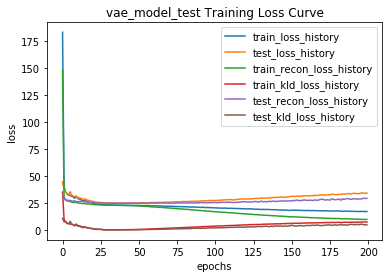

finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples


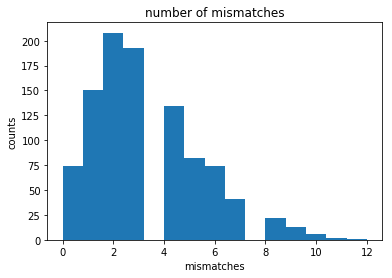

In [60]:
torch.manual_seed(np.random.randint(0, 1000))
vae = GenerativeVAE(args)
if not os.path.exists("./models/{0}".format(vae.name)):
    os.makedirs("./models/{0}".format(vae.name))
    
logger = open("./logs/vae/{0}.txt".format(vae.name), "w")
vae.fit(train_loader, test_loader, True, logger, "./models/vae/{0}.txt".format(vae.name))
vae.plot_model("./logs/vae/{0}_model_architecture".format(vae.name))
vae.plot_history("./logs/vae/{0}_training_history.png".format(vae.name))
vae.show_model(logger)
num_samples = 1000
vocabulary = get_all_amino_acids()
num_characters = len(get_all_amino_acids())
index_to_character = dict(zip(range(num_characters), vocabulary))
wild_type = get_wild_type_amino_acid_sequence() 

outputs, _ = vae.sample(num_samples = 1000, length = 238, z=None, softmax=True)
outputs = outputs.detach().numpy()
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))

plt.title("number of mismatches")
plt.hist(mismatches, bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/vae/{0}_mismatches_from_wild_type.png".format(vae.name))
if logger: 
    logger.close()

In [61]:
load_vae = GenerativeVAE(args)
load_vae.load_model("./models/{0}/checkpoint_10.pt".format(vae.name))
for parameter_name, load_weights in load_vae.model.state_dict().items():
    vae_weights = vae.model.state_dict()[parameter_name]
    assert(torch.all(torch.eq(load_weights, vae_weights)).item())

for (x, _) in test_loader:         
    x = x.to(load_vae.device)
    z, z_mean, z_var = load_vae.encoder(x, reparameterize=True)
    z_mean_2, z_var_2 = vae.encoder(x)
    assert(torch.all(torch.eq(z_mean, z_mean_2)).item())
    assert(torch.all(torch.eq(z_var, z_var_2)).item())
    recon_x = load_vae.decoder(z)
    recon_x_2 = vae.decoder(z)
    loss_1 = vae.loss(recon_x, x, z_mean, z_var).item()
    loss_2 = vae.loss(recon_x_2, x, z_mean, z_var).item()
    np.testing.assert_equal(loss_1, loss_2)

AssertionError: 